# IE.425 PROJECT

### Kaan Aslan 2017402087  |  Serdar Yıldız 2017402033

## Introduction

Kobe was one of the best basketball players around the world and had the shot accuracy of 44%. Kobe was famous for his ambition and also he was the player with record of number of shots he made. In this project, the aim is predicting whether his shot went in or not. The data provided consist of attributes with information about location, time and match which will be used to construct data mining models. First, neccesary data manipulations will be applied, then the features will be selected and models will be built. Depending on the preformance measure, ROC value, the bets model will be selected and predictions will be made.

### Data Manipulation and Required Packages

In [41]:
library(data.table)
library(caTools)
library(caret)
library(randomForest)
library(gbm)
library(dplyr)
library(Metrics)
library(ranger)
library(rpart)
library(xgboost)
library(ROCR)

In [58]:
data <- fread("C:/Users/kaan9/OneDrive/Masaüstü/IE425/kobe-train.csv",stringsAsFactors = TRUE)
data$season_general <- as.factor(case_when(data$season %in% c('1996-97','1997-98','1998-99','1999-00') ~ 1,
                                           data$season %in% c('2000-01','2001-02','2002-03','2003-04') ~ 2,
                                           data$season %in% c('2004-05','2005-06','2006-07','2007-08') ~ 3,
                                           data$season %in% c('2008-09','2009-10','2010-11','2011-12') ~ 4,
                                           data$season %in% c('2012-13','2013-14','2014-15','2015-16') ~ 5))
data$action_t <- as.character(data$action_type)
data[grepl("dunk",data$action_type,ignore.case = TRUE)]$action_t <- "DUNK"
data$action_t <- as.factor(data$action_t)
data$game_date <- as.Date(data$game_date,"%d.%m.%Y")
data$period <- as.factor(data$period)
data$game_event_id <- as.factor(data$game_event_id)
data$game_id <- as.factor(data$game_id)
data$remaining_time <- data$minutes_remaining*60 - data$seconds_remaining
data$shot_made_flag <- as.factor(data$shot_made_flag)
levels(data$shot_made_flag) <- c("NO","YES")
data$playoffs <- as.factor(data$playoffs)
levels(data$shot_zone_range) <- c("16-24 ft.","About 24 ft.","8-16 ft.","Long Shot","Less Than 8 ft.")
data[data$loc_y>300,]$shot_zone_range <- "Long Shot"
levels(data$shot_zone_area) <- c("Away","Center(C)","Left Side Center(LC)","Left Side(L)","Right Side Center(RC)","Right Side(R)")
data[data$loc_y>300,]$shot_zone_area <- "Away"
data$is_home <- 0
data[grepl("vs.",data$matchup,ignore.case = TRUE)]$is_home <- 1


In [46]:
data_test <- fread("C:/Users/kaan9/OneDrive/Masaüstü/IE425/kobe-test.csv",stringsAsFactors = TRUE)
data_test$season_general <- as.factor(case_when(data_test$season %in% c('1996-97','1997-98','1998-99','1999-00') ~ 1,
                                           data_test$season %in% c('2000-01','2001-02','2002-03','2003-04') ~ 2,
                                           data_test$season %in% c('2004-05','2005-06','2006-07','2007-08') ~ 3,
                                           data_test$season %in% c('2008-09','2009-10','2010-11','2011-12') ~ 4,
                                           data_test$season %in% c('2012-13','2013-14','2014-15','2015-16') ~ 5))
data_test$action_t <- as.character(data_test$action_type)
data_test[grepl("dunk",data_test$action_type,ignore.case = TRUE)]$action_t <- "DUNK"
data_test$action_t <- as.factor(data_test$action_t)
data_test$game_date <- as.Date(data_test$game_date,"%d.%m.%Y")
data_test$period <- as.factor(data_test$period)
data_test$game_event_id <- as.factor(data_test$game_event_id)
data_test$game_id <- as.factor(data_test$game_id)
data_test$remaining_time <- data_test$minutes_remaining*60 - data_test$seconds_remaining
data_test$playoffs <- as.factor(data_test$playoffs)
levels(data_test$shot_zone_range) <- c("16-24 ft.","About 24 ft.","8-16 ft.","Long Shot","Less Than 8 ft.")
data_test[data_test$loc_y>300,]$shot_zone_range <- "Long Shot"
levels(data_test$shot_zone_area) <- c("Away","Center(C)","Left Side Center(LC)","Left Side(L)","Right Side Center(RC)","Right Side(R)")
data_test[data_test$loc_y>300,]$shot_zone_area <- "Away"
data_test$is_home <- 0
data_test[grepl("vs.",data_test$matchup,ignore.case = TRUE)]$is_home <- 1

### Feature Selection

Feature selection and data manipulation is one of the most important parts to build acurate models. While some of the variables are numeric, most of the columns are categorical. Neccesary data type transformations applied above. First, overall effects of the variables could be measured with a simple logistic regression model which could give important insights of the data.

In [30]:
features1 <- data[,c(-1,-4,-5,-21,-22,-24,-29:-26)]

Features 1 consists of the orginal variables but shot_id, game_event_id, team_id, team_name and matchup columns are removed. These variabes can not explain the output variable.

In [24]:
glm_test1 <- glm(shot_made_flag~.,data=features1)
summary(glm_test1)


Call:
glm(formula = shot_made_flag ~ ., data = features1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0582  -0.3550  -0.2624   0.4450   1.0184  

Coefficients: (9 not defined because of singularities)
                                             Estimate Std. Error t value
(Intercept)                                -8.255e-01  3.718e+00  -0.222
action_typeAlley Oop Layup shot            -2.483e-01  7.521e-02  -3.302
action_typeCutting Layup Shot              -1.624e-01  1.946e-01  -0.835
action_typeDriving Bank shot               -2.774e-01  2.701e-01  -1.027
action_typeDriving Dunk Shot                1.509e-02  5.714e-02   0.264
action_typeDriving Finger Roll Layup Shot  -4.507e-02  8.032e-02  -0.561
action_typeDriving Finger Roll Shot        -1.145e-01  7.605e-02  -1.506
action_typeDriving Floating Bank Jump Shot  1.640e-01  4.626e-01   0.354
action_typeDriving Floating Jump Shot      -4.698e-01  2.714e-01  -1.731
action_typeDriving Hook Shot             

According to the logistic regression model, combined_shot_type gives NA which means pure correlation. Combined_shot_type must be 
correlated with action_type because its sub-class of it. Latitude and longtitude variables are also purely correlated with loc_x and loc_y variables. Those could be removed from the data. Loc_x, loc_y, shot_zone_area, shot_zone_range, shot_distance are the variables about the location of the player. Final model should consist of some of them. Loc_x and Loc_y could be seperated from the others because they are actual locations and continuous variables. Also, season gives information about the game_date  and age of the player. So, only taking season is enough for a time variable

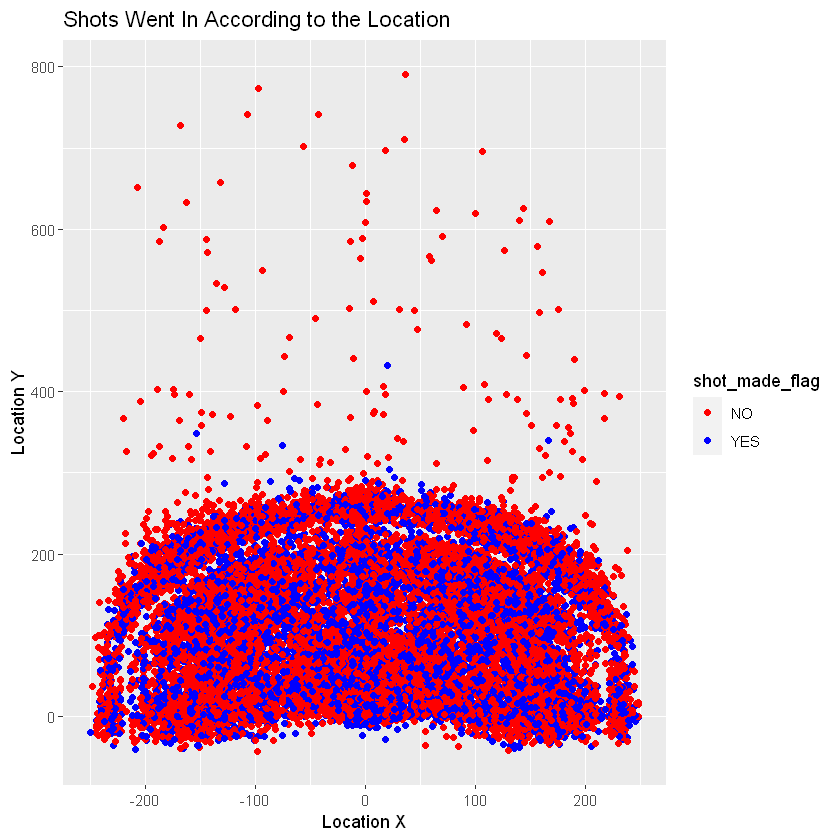

In [37]:
ggplot(data,aes(x=loc_x,y=loc_y,color=shot_made_flag)) + geom_point() +
labs(title= "Shots Went In According to the Location", x="Location X",y="Location Y") +
scale_color_manual(values=c("NO"="red","YES"="blue"))

According to the graph above, there is no obvious locations that seperate the output variable however, Kobe only made 5 succesfull shots below Y location 300. Categorical variables about location could be manipulated due to Y location.

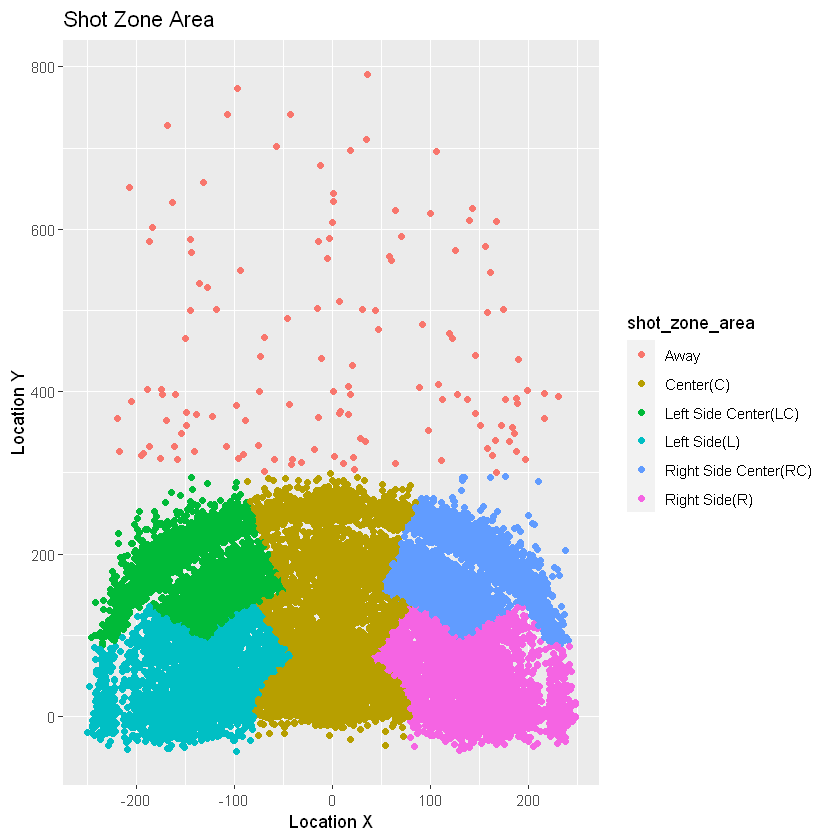

In [9]:
ggplot(data,aes(x=loc_x,y=loc_y,color=shot_zone_area)) + geom_point() +
labs(title= "Shot Zone Area", x="Location X",y="Location Y")

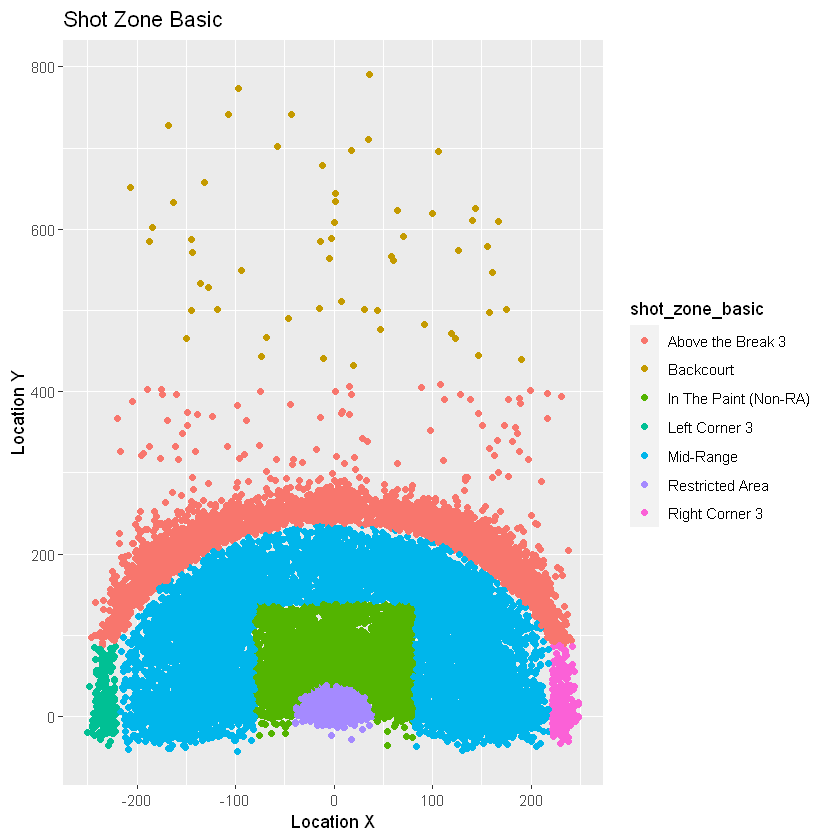

In [10]:
ggplot(data,aes(x=loc_x,y=loc_y,color=shot_zone_basic)) + geom_point() +
labs(title= "Shot Zone Basic", x="Location X",y="Location Y")

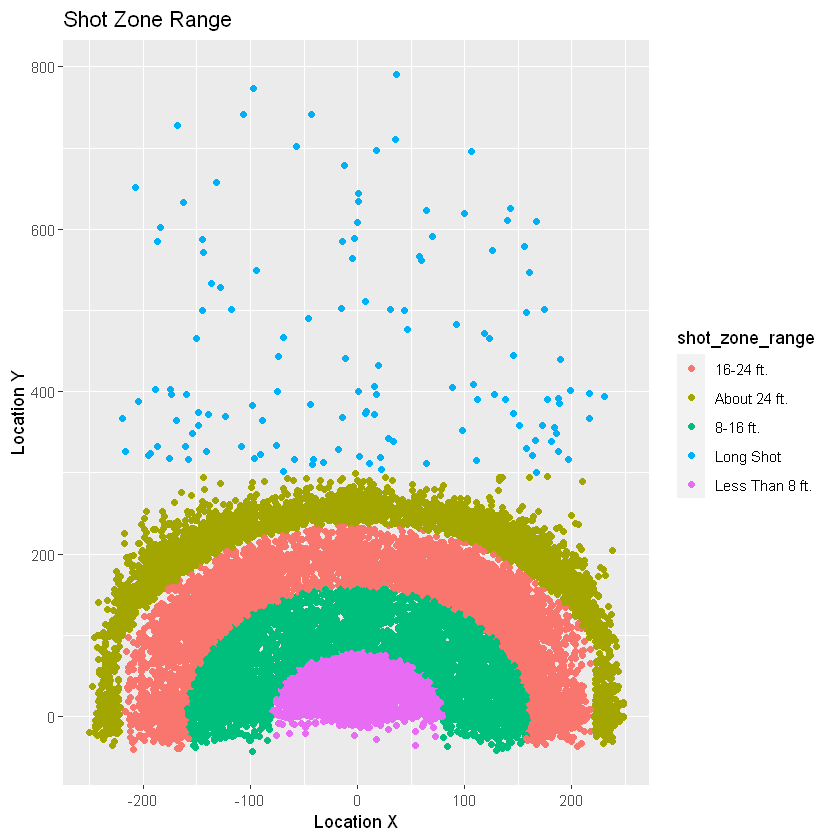

In [11]:
ggplot(data,aes(x=loc_x,y=loc_y,color=shot_zone_range)) + geom_point() +
labs(title= "Shot Zone Range", x="Location X",y="Location Y")

Shot zone area seems more accurate variable instead of shot zone basic. Distance information could be used with shot zone range instead of using a numeric variable as shot distance. For location 2 starategies will be used, only x and y locations or shot zone range and shot zone area. Since combined shot is removed, action type will be used but it has 55 levels. Levels should be reduced with the combining all dunks as a one level because dunks have very high shot accuracy. Season also has so many levels, it could be reduced with combining into 5 levels which is called season_general, because ranking of the teams in NBA changes in approximately 4 years. So, the features are seperated into 2 and will be tried in models. Features 2 consist of shot zone area, shot zone range for location information and season_general for time information while features 3 consists of X and Y locations as location information and season for the time information. Minutes remaining and seconds remaining are combined into remaining time to reduce the number of variables and both of the features includes remaining time. Both of the feature candidates consist of 10 variables with only 3 different variables about location and time.

In [47]:
features2 <- data[,c(-10:-1,-13,-14,-15,-17,-19,-24:-21)]
features3 <- data[,c(-6:-1,-9,-10,-14,-15,-24:-17,-26)]

In [25]:
glm_test2 <- glm(shot_made_flag~.,data=features2)
summary(glm_test2)


Call:
glm(formula = shot_made_flag ~ ., data = features2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0053  -0.3534  -0.2715   0.4429   0.9769  

Coefficients: (1 not defined because of singularities)
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              4.606e-01  7.539e-02   6.109 1.02e-09
period2                                 -1.079e-02  8.808e-03  -1.225 0.220678
period3                                 -1.295e-02  8.295e-03  -1.561 0.118485
period4                                 -4.406e-02  8.667e-03  -5.084 3.73e-07
period5                                 -1.639e-02  2.995e-02  -0.547 0.584274
period6                                  3.637e-02  8.881e-02   0.409 0.682200
period7                                 -6.268e-02  1.745e-01  -0.359 0.719459
playoffs1                               -5.602e-03  9.290e-03  -0.603 0.546468
shot_zone_areaCenter(C)                  3.512e-01  4.143e-0

In [26]:
glm_test3 <- glm(shot_made_flag~.,data=features3)
summary(glm_test3)


Call:
glm(formula = shot_made_flag ~ ., data = features3)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0013  -0.3502  -0.2788   0.4373   0.8434  

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              6.974e-01  6.749e-02  10.333  < 2e-16
loc_x                                    5.699e-05  2.763e-05   2.063 0.039128
loc_y                                    1.053e-04  4.294e-05   2.453 0.014162
period2                                 -9.991e-03  8.837e-03  -1.131 0.258255
period3                                 -1.431e-02  8.309e-03  -1.722 0.085027
period4                                 -4.174e-02  8.676e-03  -4.810 1.52e-06
period5                                 -1.518e-02  3.004e-02  -0.505 0.613360
period6                                  3.346e-02  8.908e-02   0.376 0.707210
period7                                 -4.724e-02  1.751e-01  -0.270 0.787255
playoffs1             

Until this point, original data is manipulated and added some new variables. Original data consists of 19 variables for models while the candidate feature datas consist of 10 decision variables. Original data has 29687 AIC in logistic regression model and candidate features have 29717 and 29717 AIC values. Original data is reduced highly in dimensions and candidate features aren't significantly worse than the original data. They will provide efficient and faster models while sustaining the same error rates. Also, new features are more logical to nature of the data. The random forest and extreme gradient boosting models will be constructed on the features 2 and features 3 data.

### Models

#### 1) Random Forest

While building random forest models, cross-validation with 10 fold will be used by caret package. Since the competition of the project will be measured by ROC, the models will use 'ROC' as metric. There are many observations and many attributes with planty of levels in the data. Therefore, method of ranger will be used because it is faster than method of randomForest.

##### 1.1) FEATURES 2

In [43]:
control1 <- trainControl(method="cv",
                        number=10,
                        summaryFunction=twoClassSummary,
                        classProbs=TRUE)

In [5]:

model <- train(shot_made_flag ~.-season, 
               data = features2,
               method = 'ranger',
               metric = 'ROC',
               trControl = control1,
               tuneGrid = expand.grid(.mtry=3:8,.splitrule="gini",.min.node.size=c(1:3)*5))
model

OUTPUT HERE (MODEL)

In model, mtry values of 3,4,5,6,7, and 8 were used. Also, values of 5, 10, and 15 were used as min.node.size. The best ROC value is 0.694. Next, second model will be built below.

In [ ]:
model2 <- train(shot_made_flag ~.-season, 
               data = features2,
               method = 'ranger',
               metric = 'ROC',
               trControl = control1,
               tuneGrid = expand.grid(.mtry=3:8,.splitrule="gini",.min.node.size=c(1:3)*50))

OUTPUT HERE (MODEL2)

In model2, mtry values of 3,4,5,6,7, and 8 were used again. Then, values of 50, 100, and 150 were used as min.node.size in order to check whether the result is improved. The best ROC value is 0.695, which is slightly higher than first model. Next, the parameter of ntree will be changed in a for loop.

In [19]:
models <- list()
for(ntree in (4:9)*100){
    model <- train(shot_made_flag ~.-season, 
                data = features2,
                method = 'ranger',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = expand.grid(.mtry=3:8,.splitrule="gini",.min.node.size=c(3:5)*100),
                num.trees=ntree)
    models[[toString(ntree)]] <- model
}
models

OUTPUT HERE (MODELS/400:900)

In models list, there are 6 different models with different size of ntree. Also, values of 300, 400, and 500 were used as min.node.size while values of mtry parameter did not change. The best ROC value is approximately 0.698. Features 3 will be modeled in the next step.

##### 1.2) FEATURES 3

In [47]:
 model_f3 <- train(shot_made_flag ~., 
                data = features3,
                method = 'ranger',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = expand.grid(.mtry=3:8,.splitrule="gini",.min.node.size=c(1:3)*100),
                num.trees=500)
model_f3

OUTPUT HERE (MODELF3-1)

n model_f3, training set was features3. mtry values of 3,4,5,6,7, and 8 were used and values of 100, 200, and 300 were used as min.node.size. The best ROC value is 0.705. Next model will be build with min.node.size values of 400, 500, and 600.

In [ ]:
 model_f3_2 <- train(shot_made_flag ~., 
                data = features3,
                method = 'ranger',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = expand.grid(.mtry=3:8,.splitrule="gini",.min.node.size=c(4:6)*100),
                num.trees=500)
model_f3_2

OUTPUT HERE (MODELF3-2)

The best result is approximately 0.703 which is slightly worse than previous model.

In [49]:
 model_f3_3 <- train(shot_made_flag ~., 
                data = features3,
                method = 'ranger',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = expand.grid(.mtry=3:8,.splitrule="gini",.min.node.size=c(1:3)*50),
                num.trees=500)
model_f3_3

OUTPUT HERE (MODELF3-3)

After the last grid search, features 3 gave better results. So, features 3 will be used in the next models. The best model has 0.705 ROC value and has parameters mtry=8, min.node.size=150 and num.trees=500. Optimal ranger model will be constructed on these parameters.

In [56]:
model_opt_rf <- train(shot_made_flag ~., 
                data = features3,
                method = 'ranger',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = expand.grid(.mtry=8,.splitrule="gini",.min.node.size=150),
                num.trees=500)
model_opt_rf

Random Forest 

23127 samples
    8 predictor
    2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 20814, 20814, 20815, 20814, 20814, 20814, ... 
Resampling results:

  ROC        Sens       Spec    
  0.7026908  0.8472933  0.473541

Tuning parameter 'mtry' was held constant at a value of 8
Tuning
 parameter 'splitrule' was held constant at a value of gini
Tuning
 parameter 'min.node.size' was held constant at a value of 150

In [68]:
predicts_rf <- predict(model_opt_rf,newdata=data_test,type="prob")
sub1 <- data.table(shot_id=data_test$V1,shot_made_flag=predicts_rf[,2])
fwrite(sub1,file="sub1.csv")

KAGGLE OUTPUT RF

Predictions with the optimum Random Forest model has submitted to Kaggle and gave AUC value of 0.69964. Extreme gradient boosting algorithm will be used in the next step to obtain a improvement model and better AUC values.

### 2) Gradient Boosting Machines

Again, cross validation with 10 fold will be used to built GBM models. In caret library, xgbTree will be used because it gives the results faster than gbm method. Moreover, ROC will be the measurement of the models.

##### 2.1) FEATURES 2

In [7]:
grid1 <- expand.grid(nrounds = 100,
                     max_depth = c(5,15,30),  
                     eta = c(1,4,8)*0.01,
                     gamma=0,
                     colsample_bytree= 0.9,
                     min_child_weight= c(5,15,30),
                     subsample= 0.9)

model_xgb <- train(shot_made_flag ~., 
                data = features2,
                method = 'xgbTree',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = grid1)

+ Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight= 5, subsample=0.9, nrounds=100 
- Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight= 5, subsample=0.9, nrounds=100 
+ Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight=15, subsample=0.9, nrounds=100 
- Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight=15, subsample=0.9, nrounds=100 
+ Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight=30, subsample=0.9, nrounds=100 
- Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight=30, subsample=0.9, nrounds=100 
+ Fold01: eta=0.01, max_depth=15, gamma=0, colsample_bytree=0.9, min_child_weight= 5, subsample=0.9, nrounds=100 
- Fold01: eta=0.01, max_depth=15, gamma=0, colsample_bytree=0.9, min_child_weight= 5, subsample=0.9, nrounds=100 
+ Fold01: eta=0.01, max_depth=15, gamma=0, colsample_bytree=0.9, min_child_weight=15, su

Selecting tuning parameters
Fitting nrounds = 100, max_depth = 5, eta = 0.04, gamma = 0, colsample_bytree = 0.9, min_child_weight = 5, subsample = 0.9 on full training set


In [8]:
model_xgb

eXtreme Gradient Boosting 

23127 samples
    8 predictor
    2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 20814, 20814, 20815, 20814, 20815, 20814, ... 
Resampling results across tuning parameters:

  eta   max_depth  min_child_weight  ROC        Sens       Spec     
  0.01   5          5                0.7007655  0.8467462  0.4719919
  0.01   5         15                0.6999567  0.8474487  0.4716042
  0.01   5         30                0.6985525  0.8415934  0.4755777
  0.01  15          5                0.6920162  0.8490102  0.4623970
  0.01  15         15                0.6948850  0.8506493  0.4661764
  0.01  15         30                0.6958546  0.8424521  0.4750931
  0.01  30          5                0.6882400  0.8316004  0.4732521
  0.01  30         15                0.6938981  0.8482296  0.4678245
  0.01  30         30                0.6956172  0.8420618  0.4750934
  0.04   5          5                0.7025385  

Different parameters were used in grid and model_xgb was built with them. The ROC value of best model is 0.702. Next, features3 will be the training set and gbm models will be built by it.

##### 2.2) FEATURES 3

In [9]:
grid2 <- expand.grid(nrounds = 100,
                     max_depth = c(5,10,15),  
                     eta = c(1,4,8)*0.01,
                     gamma=0,
                     colsample_bytree= 0.9,
                     min_child_weight= c(5,15,30),
                     subsample= 0.9)

model_xgb2 <- train(shot_made_flag ~., 
                data = features3,
                method = 'xgbTree',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = grid1)

+ Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight= 5, subsample=0.9, nrounds=100 
- Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight= 5, subsample=0.9, nrounds=100 
+ Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight=15, subsample=0.9, nrounds=100 
- Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight=15, subsample=0.9, nrounds=100 
+ Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight=30, subsample=0.9, nrounds=100 
- Fold01: eta=0.01, max_depth= 5, gamma=0, colsample_bytree=0.9, min_child_weight=30, subsample=0.9, nrounds=100 
+ Fold01: eta=0.01, max_depth=15, gamma=0, colsample_bytree=0.9, min_child_weight= 5, subsample=0.9, nrounds=100 
- Fold01: eta=0.01, max_depth=15, gamma=0, colsample_bytree=0.9, min_child_weight= 5, subsample=0.9, nrounds=100 
+ Fold01: eta=0.01, max_depth=15, gamma=0, colsample_bytree=0.9, min_child_weight=15, su

Selecting tuning parameters
Fitting nrounds = 100, max_depth = 5, eta = 0.08, gamma = 0, colsample_bytree = 0.9, min_child_weight = 15, subsample = 0.9 on full training set


In [11]:
model_xgb2

eXtreme Gradient Boosting 

23127 samples
    8 predictor
    2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 20814, 20814, 20815, 20815, 20815, 20814, ... 
Resampling results across tuning parameters:

  eta   max_depth  min_child_weight  ROC        Sens       Spec     
  0.01   5          5                0.7010607  0.8466687  0.4722827
  0.01   5         15                0.7023754  0.8472931  0.4722826
  0.01   5         30                0.7007273  0.8411258  0.4763531
  0.01  15          5                0.6985553  0.8497138  0.4660805
  0.01  15         15                0.7008726  0.8512752  0.4667572
  0.01  15         30                0.7018592  0.8412040  0.4756738
  0.01  30          5                0.6958418  0.8354272  0.4776138
  0.01  30         15                0.7000886  0.8469811  0.4696654
  0.01  30         30                0.7008362  0.8402672  0.4753834
  0.04   5          5                0.7045096  

In [13]:
grid3 <- expand.grid(nrounds = c(100,150),
                     max_depth = c(1,2,3,4),  
                     eta = c(5,6,7,9)*0.01,
                     gamma=0,
                     colsample_bytree= 0.9,
                     min_child_weight= c(15,20,25,35),
                     subsample= 0.9)

model_xgb3 <- train(shot_made_flag ~., 
                data = features3,
                method = 'xgbTree',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = grid3)

In [14]:
model_xgb3

eXtreme Gradient Boosting 

23127 samples
    8 predictor
    2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 20814, 20814, 20814, 20815, 20814, 20814, ... 
Resampling results across tuning parameters:

  eta   max_depth  min_child_weight  nrounds  ROC        Sens       Spec     
  0.05  1          15                100      0.6753986  0.8419081  0.4753838
  0.05  1          15                150      0.6847939  0.8420642  0.4753838
  0.05  1          20                100      0.6754605  0.8419081  0.4753838
  0.05  1          20                150      0.6847279  0.8421422  0.4753838
  0.05  1          25                100      0.6763612  0.8419081  0.4753838
  0.05  1          25                150      0.6860617  0.8419081  0.4753838
  0.05  1          35                100      0.6760248  0.8419081  0.4753838
  0.05  1          35                150      0.6853214  0.8419081  0.4752868
  0.05  2          15               

In [15]:
grid4 <- expand.grid(nrounds = c(150,200),
                     max_depth = c(4,5,6,7),  
                     eta = c(8,9,10,11,12)*0.01,
                     gamma=0,
                     colsample_bytree= 0.9,
                     min_child_weight= c(10,15,20,25),
                     subsample= 0.9)

model_xgb4 <- train(shot_made_flag ~., 
                data = features3,
                method = 'xgbTree',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = grid4)

In [16]:
model_xgb4

eXtreme Gradient Boosting 

23127 samples
    8 predictor
    2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 20814, 20814, 20814, 20815, 20814, 20815, ... 
Resampling results across tuning parameters:

  eta   max_depth  min_child_weight  nrounds  ROC        Sens       Spec     
  0.08  4          10                150      0.7030740  0.8544761  0.4648173
  0.08  4          10                200      0.7026417  0.8540077  0.4650110
  0.08  4          15                150      0.7035607  0.8522903  0.4666591
  0.08  4          15                200      0.7029746  0.8522904  0.4644301
  0.08  4          20                150      0.7040852  0.8528370  0.4676276
  0.08  4          20                200      0.7035407  0.8528367  0.4667553
  0.08  4          25                150      0.7023470  0.8518221  0.4678219
  0.08  4          25                200      0.7022304  0.8526808  0.4665622
  0.08  5          10               

In [58]:
grid5 <- expand.grid(nrounds = 100,
                     max_depth = 5,  
                     eta = 0.08,
                     gamma=0,
                     colsample_bytree= 0.9,
                     min_child_weight= 20,
                     subsample= 0.9)

model_xgb_opt <- train(shot_made_flag ~., 
                data = features3,
                method = 'xgbTree',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = grid5)

In [59]:
model_xbg_opt

eXtreme Gradient Boosting 

23127 samples
    8 predictor
    2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 20814, 20814, 20815, 20814, 20814, 20815, ... 
Resampling results:

  ROC       Sens      Spec     
  0.703458  0.851121  0.4673424

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 20
Tuning parameter 'subsample' was held
 constant at a value of 0.9

In [66]:
predicts_xgb <- predict(model_xgb_opt,newdata=data_test,type="prob")
sub2 <- data.table(shot_id=data_test$V1,shot_made_flag=predicts_xgb[,2])
fwrite(sub2,file="sub2.csv")

KAGGLE OUTPUT HERE XGB

Above, many parameters are tried with grid search and the best ROC value is 0.703 with paramters nrounds = 100, max_depth = 5, eta = 0.08, gamma=0, colsample_bytree= 0.9, min_child_weight= 20, subsample= 0.9 parameters. Predictions with gbm model has submitted to Kaggle and obtained 0.707 which is better than the first submission with random forest model.

##### 2.3) An Improvement Step

After searching for improvements, court locations could influence the shot accuracy because of the crowd in the court. So, court locations, home or away match, is subtracted from the matchup column. Matchups with "@" symbol indicates away matches while matchups with "vs." symbol indicates home matches. A binary variable is_home is added to the data to improve the model.

In [84]:
grid6 <- expand.grid(nrounds = 100,
                     max_depth = c(4,5,6),  
                     eta = c(0.06,0.08,0.1),
                     gamma=0,
                     colsample_bytree= 0.9,
                     min_child_weight= c(10,15,20),
                     subsample= 0.9)

model_xgb6 <- train(shot_made_flag ~., 
                data = features3,
                method = 'xgbTree',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = grid6)

In [85]:
model_xgb6

eXtreme Gradient Boosting 

23127 samples
    9 predictor
    2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 20815, 20814, 20814, 20815, 20814, 20814, ... 
Resampling results across tuning parameters:

  eta   max_depth  min_child_weight  ROC        Sens       Spec     
  0.06  4          10                0.7054858  0.8526817  0.4676278
  0.06  4          15                0.7051420  0.8512765  0.4680159
  0.06  4          20                0.7055533  0.8506521  0.4685976
  0.06  5          10                0.7075718  0.8550238  0.4658833
  0.06  5          15                0.7067502  0.8526819  0.4679192
  0.06  5          20                0.7070567  0.8531502  0.4663687
  0.06  6          10                0.7070117  0.8558830  0.4656892
  0.06  6          15                0.7060130  0.8536968  0.4658840
  0.06  6          20                0.7070843  0.8538528  0.4672409
  0.08  4          10                0.7062804  

In [8]:
grid7 <- expand.grid(nrounds = 100,
                     max_depth = c(4,5,6),  
                     eta = c(0.03,0.04,0.05),
                     gamma=0,
                     colsample_bytree= 0.9,
                     min_child_weight= c(10,15,20),
                     subsample= 0.9)

model_xgb7 <- train(shot_made_flag ~., 
                data = features3,
                method = 'xgbTree',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = grid7)

In [9]:
model_xgb7

eXtreme Gradient Boosting 

23127 samples
    9 predictor
    2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 20815, 20816, 20814, 20814, 20814, 20814, ... 
Resampling results across tuning parameters:

  eta   max_depth  min_child_weight  ROC        Sens       Spec     
  0.03  4          10                0.7039080  0.8462792  0.4724765
  0.03  4          15                0.7046260  0.8460450  0.4719922
  0.03  4          20                0.7042796  0.8457323  0.4719922
  0.03  5          10                0.7060108  0.8474504  0.4719925
  0.03  5          15                0.7063208  0.8481529  0.4708291
  0.03  5          20                0.7062307  0.8483089  0.4706354
  0.03  6          10                0.7068335  0.8494021  0.4700536
  0.03  6          15                0.7060405  0.8494802  0.4704414
  0.03  6          20                0.7060020  0.8494803  0.4704413
  0.04  4          10                0.7047487  

In [48]:
grid_opt <- expand.grid(nrounds = 100,
                     max_depth = 5,  
                     eta = 0.06,
                     gamma=0,
                     colsample_bytree= 0.8,
                     min_child_weight= 10,
                     subsample= 0.9)

model_xgb_opt2 <- train(shot_made_flag ~., 
                data = features3,
                method = 'xgbTree',
                metric = 'ROC',
                trControl = control1,
                tuneGrid = grid_opt)

In [35]:
model_xgb_opt2

eXtreme Gradient Boosting 

23127 samples
    9 predictor
    2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 20814, 20814, 20815, 20814, 20814, 20815, ... 
Resampling results:

  ROC        Sens       Spec     
  0.7064741  0.8536958  0.4667569

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 10
Tuning parameter 'subsample' was held
 constant at a value of 0.9

After the addition of the new variable, the best model gave 0.706 ROC value which is better than the previous models. 

In [49]:
predicts_xgb2 <- predict(model_xgb_opt2,newdata=data_test,type="prob")
sub3 <- data.table(shot_id=data_test$V1,shot_made_flag=predicts_xgb2[,2])
fwrite(sub3,file="sub3.csv")

KAGGLE FINAL

After the conclusion of the competition in the Kaggle, optimum model has the AUC value of 0.71867 and took 13th place.

### Conclusion

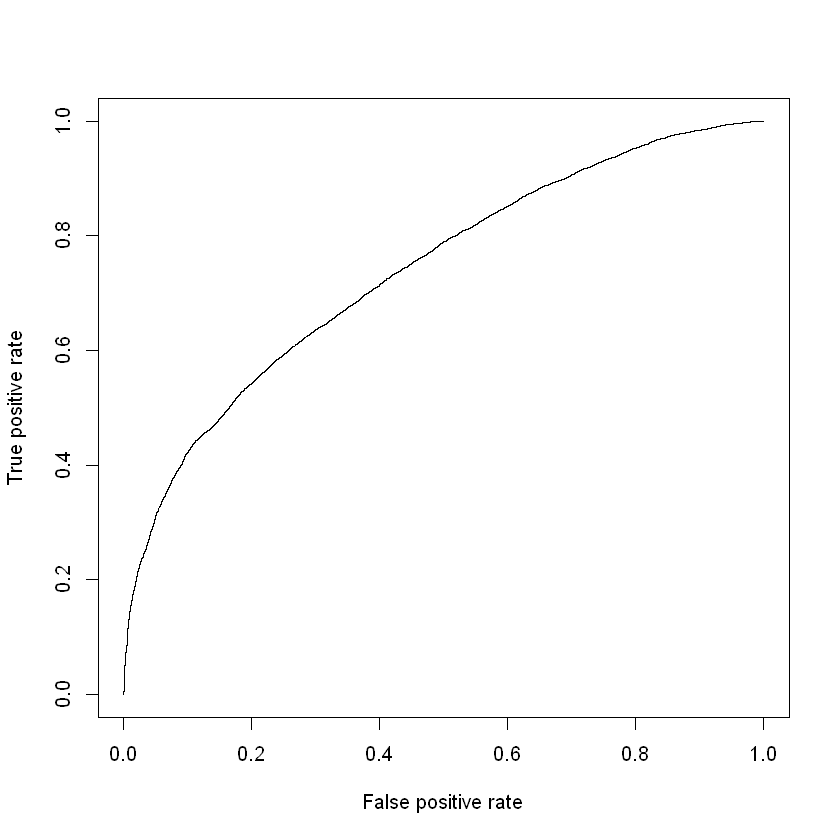

In [57]:
res <- predict(model_xgb_opt2,newdata=features3,type="prob")
pred <- prediction(res[,2],features3$shot_made_flag)
perf <- performance(pred,"tpr","fpr")
plot(perf)

This assignment aims to predict Kobe Bryant's shots with success. The data was given with 24 attributes and a target column named shot_made_flag. First, necessary data manipulations and merging processes were made. Secondly, the models were built with two different training sets containing different attributes. Caret library was used to build the models. Algorithms of Random Forest and GBM were built many times and the best result was obtained by GBM with features3 training set. Finally, the predictions on the test set were obtained and uploaded to kaggle competition.